In [105]:
## Imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn import metrics
from sklearn.model_selection import KFold

In [100]:
df = pd.read_csv('./data/compas_data_combined_matches.csv')


In [ ]:
columns_to_drop = ['FirstName', 'LastName', 'DateOfBirth', 'id', 'v_decile_score', 'DecileScore_Risk of Failure to Appear','race', 'DecileScore_Risk of Recidivism', 'DecileScore_Risk of Violence', 'RawScore_Risk of Failure to Appear', 'RawScore_Risk of Recidivism', 'RawScore_Risk of Violence', '_merge', 'sex', 'score_text', 'Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
rf_dataset = df.drop(columns=columns_to_drop)
rf_dataset.columns

Index(['priors_count', 'age', 'two_year_recid', 'is_recid', 'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'c_charge_desc', 'above_45',
       'below_25', 'is_felon', 'is_misdemeanor', 'Female', 'Male',
       'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American',
       'Other', 'Language_English', 'Language_Spanish',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Separated', 'MaritalStatus_Significant Other',
       'MaritalStatus_Single', 'MaritalStatus_Unknown',
       'MaritalStatus_Widowed'],
      dtype='object')

In [102]:
# Remove Nans, row wise and column wise 
na_counts = rf_dataset.isna().sum()
na_columns = na_counts[na_counts > 0] 
nans = na_columns.to_dict()
columns_to_remove = []
for key in nans.keys():
    columns_to_remove.append(key)

rf_dataset_columns_removed = rf_dataset.drop(columns=columns_to_remove)
rf_dataset_rows_removed = rf_dataset.dropna()
print(len(rf_dataset_rows_removed))
labels_rows_removed = rf_dataset_rows_removed.two_year_recid
labels_columns_removed = rf_dataset_columns_removed.two_year_recid

rf_dataset_columns_removed=rf_dataset_columns_removed.drop(columns=['two_year_recid', 'is_recid'])
rf_dataset_rows_removed=rf_dataset_rows_removed.drop(columns=['two_year_recid', 'is_recid'])


5084


In [85]:
rf_dataset_columns_removed.head(5)

,priors_count,age,juv_fel_count,juv_misd_count,juv_other_count,above_45,below_25,is_felon,is_misdemeanor,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,0.0,69.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4.0,24.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,23.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2.0,43.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [86]:
rf_dataset_rows_removed.head(5)

,priors_count,age,juv_fel_count,juv_misd_count,juv_other_count,c_charge_desc,above_45,below_25,is_felon,is_misdemeanor,...,Other,Language_English,Language_Spanish,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Significant Other,MaritalStatus_Single,MaritalStatus_Unknown,MaritalStatus_Widowed
1,0.0,34.0,0.0,0.0,0.0,Felony Battery w/Prior Convict,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,24.0,0.0,0.0,1.0,Possession of Cocaine,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,23.0,0.0,1.0,0.0,Possession of Cannabis,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,14.0,41.0,0.0,0.0,0.0,Possession Burglary Tools,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.0,21.0,0.0,0.0,0.0,Insurance Fraud,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [87]:
def grid_search(X_train, y_train):
    clf=RF(random_state=0)

    param_grid = {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 10, 20, 30],     
        'max_features': ['sqrt', 'log2', None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

# 

In [103]:
# EXPERIMENT 1
# remove NANs column wise
# Drop c_charge_desc
#rf_dataset_columns_removed_drop_charge = rf_dataset_columns_removed.drop(columns=['c_charge_desc'])
kf=KFold(n_splits=10)
X_train, X_test, y_train, y_test=train_test_split(rf_dataset_columns_removed,
                                                  labels_columns_removed,
                                                  test_size=0.33,
                                                  random_state=0)
best_params = grid_search(X_train, y_train)
print(best_params)
clf=RF(**best_params, random_state=42)
clf.fit(X_train,y_train)
score=clf.score(X_test,y_test)
cvscore=cross_val_score(clf,X_test,y_test,cv=10)
print('Experiment 1 (col deleation, no charge) results')
print(score)
print(cvscore)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

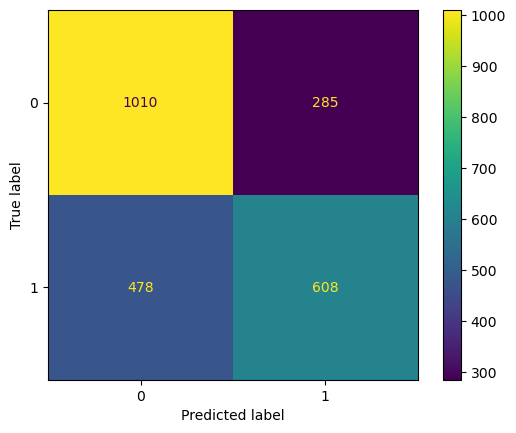

In [104]:
preds=clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test,preds)
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                          display_labels = [0, 1])
cm_display.plot()

In [91]:
# EXPERIMENT 2
# remove NANs row wise
# Drop c_charge_desc
rf_dataset_rows_removed_drop_charge = rf_dataset_rows_removed.drop(columns=['c_charge_desc'])

kf=KFold(n_splits=10)
X_train, X_test, y_train, y_test=train_test_split(rf_dataset_rows_removed_drop_charge,
                                                  labels_rows_removed,
                                                  test_size=0.33,
                                                  random_state=0)
best_params = grid_search(X_train, y_train)
print(best_params)
clf=RF(**best_params, random_state=42)
clf.fit(X_train,y_train)
score=clf.score(X_test,y_test)
cvscore=cross_val_score(clf,X_test,y_test,cv=10)
print('Experiment 2 (rows deleation, no charge) results')
print(score)
print(cvscore)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

In [98]:
# EXPERIMENT 3
# remove NANs col wise
# Keep c_charge_desc
na_counts = rf_dataset.isna().sum()
na_columns = na_counts[na_counts > 0] 
nans = na_columns.to_dict()
columns_to_remove = []
for key in nans.keys():
    columns_to_remove.append(key)
columns_to_remove.remove('c_charge_desc')
rf_dataset_columns_removed = rf_dataset.drop(columns=columns_to_remove)
rf_dataset_columns_removed = rf_dataset_columns_removed.dropna()
charge_desc_dummies = pd.get_dummies(rf_dataset_columns_removed['c_charge_desc']).astype(int)

rf_dataset_columns_removed = rf_dataset_columns_removed.merge(charge_desc_dummies, left_index=True, right_index=True, how='left')
rf_dataset_columns_removed = rf_dataset_columns_removed.drop(columns='c_charge_desc')
labels_cols_removed = rf_dataset_columns_removed.two_year_recid
rf_dataset_columns_removed = rf_dataset_columns_removed.drop(columns=['two_year_recid', 'is_recid'])
kf=KFold(n_splits=10)
X_train, X_test, y_train, y_test=train_test_split(rf_dataset_columns_removed,
                                                  labels_cols_removed,
                                                  test_size=0.33,
                                                  random_state=0)
best_params = grid_search(X_train, y_train)
print(best_params)
clf=RF(**best_params, random_state=42)
clf.fit(X_train,y_train)
score=clf.score(X_test,y_test)
cvscore=cross_val_score(clf,X_test,y_test,cv=10)
print('Experiment  (rows deleation, charge) results')
print(score)
print(cvscore)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

In [99]:
# EXPERIMENT 4
# remove NANs row wise
# Keep c_charge_desc
charge_desc_dummies = pd.get_dummies(rf_dataset_rows_removed['c_charge_desc']).astype(int)
rf_dataset_rows_keep_charge = rf_dataset_rows_removed.merge(charge_desc_dummies, left_index=True, right_index=True, how='left')
rf_dataset_rows_keep_charge = rf_dataset_rows_keep_charge.drop(columns=['c_charge_desc'])
kf=KFold(n_splits=10)
X_train, X_test, y_train, y_test=train_test_split(rf_dataset_rows_keep_charge,
                                                  labels_rows_removed,
                                                  test_size=0.33,
                                                  random_state=0)
best_params = grid_search(X_train, y_train)
print(best_params)
clf=RF(**best_params, random_state=42)
clf.fit(X_train,y_train)
score=clf.score(X_test,y_test)
cvscore=cross_val_score(clf,X_test,y_test,cv=10)
print('Experiment  (rows deleation, charge) results')
print(score)
print(cvscore)




Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

In [130]:
df = pd.read_csv('./data/compas_data_combined_matches.csv')
columns_to_drop = ['FirstName', 'LastName', 'DateOfBirth', 'id', 'v_decile_score', 'DecileScore_Risk of Failure to Appear','race', 'DecileScore_Risk of Recidivism', 'DecileScore_Risk of Violence', 'RawScore_Risk of Failure to Appear', 'RawScore_Risk of Recidivism', 'RawScore_Risk of Violence', '_merge', 'sex', 'score_text', 'c_charge_desc']
rf_dataset = df.drop(columns=columns_to_drop)
rf_dataset.columns


Index(['priors_count', 'age', 'two_year_recid', 'is_recid', 'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'c_charge_desc', 'above_45',
       'below_25', 'is_felon', 'is_misdemeanor', 'Female', 'Male',
       'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American',
       'Other', 'Language_English', 'Language_Spanish',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Separated', 'MaritalStatus_Significant Other',
       'MaritalStatus_Single', 'MaritalStatus_Unknown',
       'MaritalStatus_Widowed', 'embeddings', 'aggregated_category'],
      dtype='object')

In [ ]:
# Remove Nans, row wise and column wise 
na_counts = rf_dataset.isna().sum()
na_columns = na_counts[na_counts > 0] 
nans = na_columns.to_dict()
columns_to_remove = []
for key in nans.keys():
    columns_to_remove.append(key)
rf_dataset_columns_removed = rf_dataset.drop(columns=columns_to_remove)
rf_dataset_columns_removed.columns

Index(['priors_count', 'age', 'two_year_recid', 'is_recid', 'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'c_charge_desc', 'above_45',
       'below_25', 'is_felon', 'is_misdemeanor', 'Female', 'Male',
       'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American',
       'Other', 'embeddings', 'aggregated_category'],
      dtype='object')

In [ ]:
# EXPERIMENT 5
# remove NANs col wise
# Use clustered c_charge_desc
rf_dataset_columns_removed = rf_dataset_columns_removed.dropna()
labels_cols_removed = rf_dataset_columns_removed.two_year_recid
rf_dataset_columns_removed = rf_dataset_columns_removed.drop(columns=['two_year_recid', 'is_recid'])
kf=KFold(n_splits=10)
X_train, X_test, y_train, y_test=train_test_split(rf_dataset_columns_removed,
                                                  labels_cols_removed,
                                                  test_size=0.33,
                                                  random_state=0)
best_params = grid_search(X_train, y_train)
print(best_params)
clf=RF(**best_params, random_state=42)
clf.fit(X_train,y_train)
score=clf.score(X_test,y_test)
cvscore=cross_val_score(clf,X_test,y_test,cv=10)
print('Experiment  (rows deleation, charge) results')
print(score)
print(cvscore)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_